## Test Temporal Fusion Transformers V3

Using device: cpu


/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_66521/3014730643.py:184: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


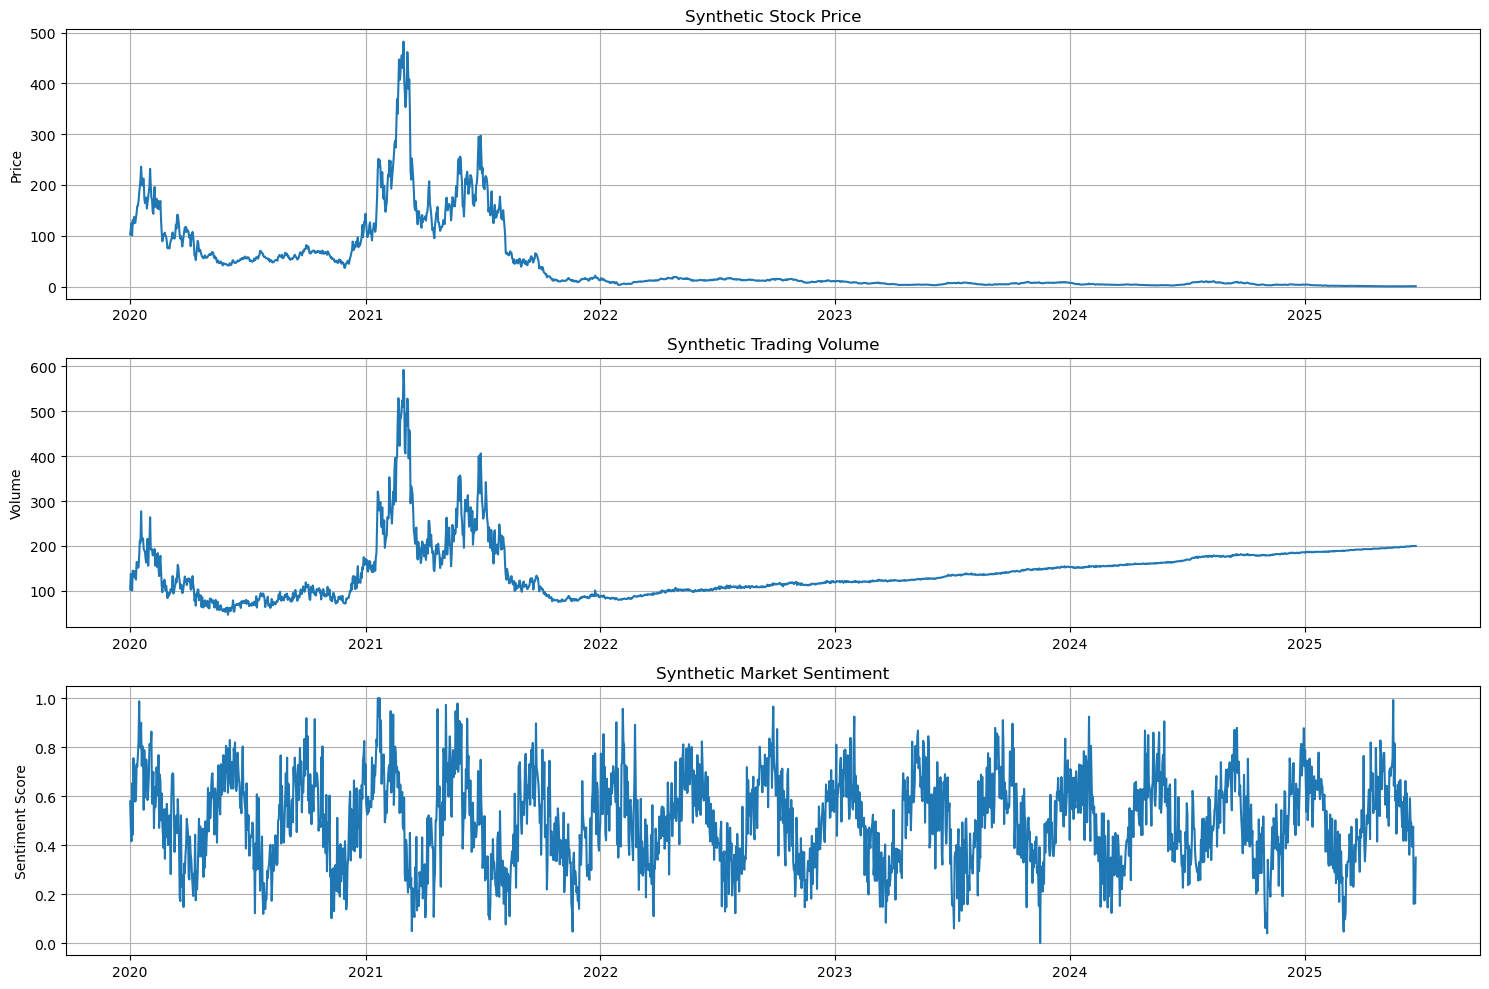

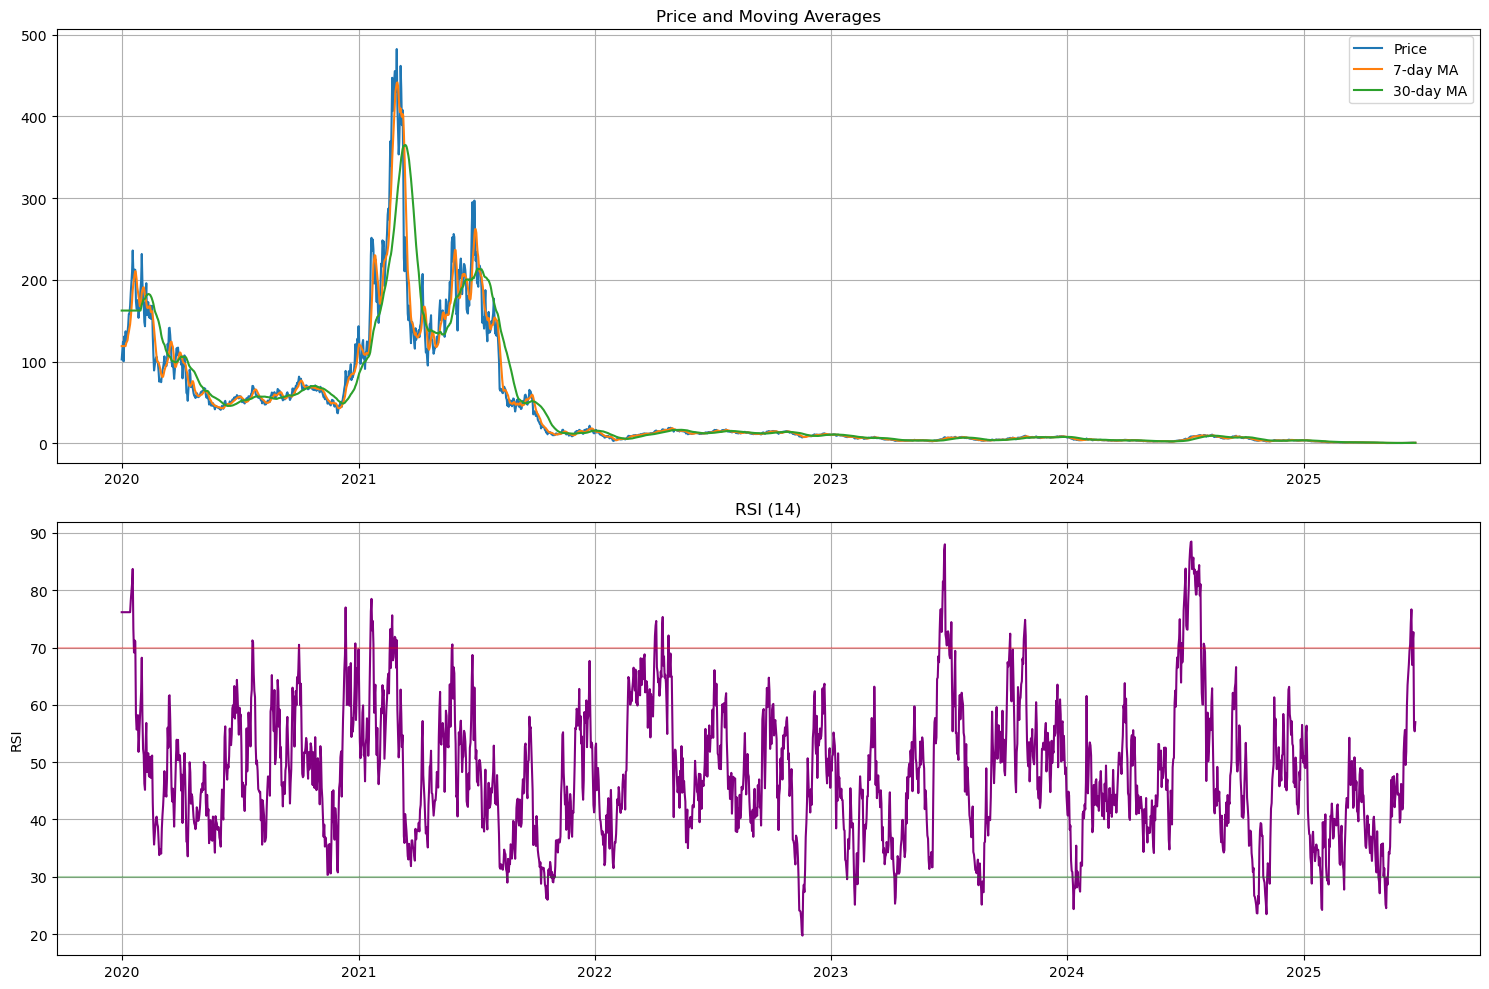

Train data shape: torch.Size([1571, 7])
Test data shape: torch.Size([393, 7])
Encoder input 0 shape: torch.Size([1571, 30, 6])
Encoder input 1 shape: torch.Size([1571, 30, 18])
Decoder input 0 shape: torch.Size([1571, 7, 6])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from datetime import datetime, timedelta

# Import our TFT implementation
# Assuming you saved the TFT code in a file called temporal_fusion_transformer.py
from models.tft_v3 import TemporalFusionTransformer

# ====================== Set Random Seeds for Reproducibility ======================
# IMPORTANT: Change these seed values to generate different datasets
RANDOM_SEED = 88  # Master seed for overall reproducibility
# REGIME_SEED = 123  # Controls market regime changes
# EVENT_SEED = 456  # Controls random events/jumps
# NOISE_SEED = 789  # Controls daily price noise

# Example seed combinations for different dataset characteristics:

# More balanced regimes with moderate volatility
# REGIME_SEED = 456
# EVENT_SEED = 789
# NOISE_SEED = 101

# Bearish early, bullish late dataset
# REGIME_SEED = 222
# EVENT_SEED = 333
# NOISE_SEED = 444

# Highly volatile dataset
REGIME_SEED = 555
EVENT_SEED = 666 
NOISE_SEED = 777

# Set seeds
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====================== 1. Generate Synthetic Financial Data ======================

def generate_synthetic_financial_data(n_samples=2000, start_date="2020-01-01", 
                                     regime_seed=REGIME_SEED, 
                                     event_seed=EVENT_SEED,
                                     noise_seed=NOISE_SEED):
    """
    Generate synthetic stock price data with market regimes, trends, seasonality, and events.
    
    Args:
        n_samples: Number of days to generate
        start_date: Starting date for the time series
        regime_seed: Seed controlling market regime transitions (bull/bear/sideways)
        event_seed: Seed controlling random price events/jumps
        noise_seed: Seed controlling daily price noise
    """
    dates = pd.date_range(start=start_date, periods=n_samples)
    t = np.arange(n_samples)
    
    # Set regime seed for regime-related randomness
    regime_rng = np.random.RandomState(regime_seed)
    
    # Generate market regimes (bull, bear, sideways)
    regime_changes = np.sort(regime_rng.choice(range(100, n_samples-100), size=6, replace=False))
    regimes = np.zeros(n_samples)
    
    current_regime = regime_rng.choice([0, 1, 2])  # 0=bull, 1=bear, 2=sideways
    for i in range(len(regime_changes) + 1):
        start_idx = 0 if i == 0 else regime_changes[i-1]
        end_idx = n_samples if i == len(regime_changes) else regime_changes[i]
        regimes[start_idx:end_idx] = current_regime
        current_regime = (current_regime + regime_rng.choice([1, 2])) % 3
    
    # Base price with trend dependent on regime
    price = 100 * np.ones(n_samples)
    for i in range(1, n_samples):
        if regimes[i] == 0:  # Bull
            drift = 0.08  # Positive trend
            vol = 1.0
        elif regimes[i] == 1:  # Bear
            drift = -0.05  # Negative trend
            vol = 1.8
        else:  # Sideways
            drift = 0.01
            vol = 0.8
            
        price[i] = price[i-1] * (1 + regime_rng.normal(drift/252, vol/np.sqrt(252)))
    
    # Set event seed for event-related randomness
    event_rng = np.random.RandomState(event_seed)
    
    # Add weekly seasonality (5-day pattern)
    weekly = 0.005 * price * np.sin(2 * np.pi * t / 5)
    
    # Add monthly seasonality
    monthly = 0.02 * price * np.sin(2 * np.pi * t / 30)
    
    # Add quarterly seasonality
    quarterly = 0.05 * price * np.sin(2 * np.pi * t / 90)
    
    # Random events (occasional price jumps with mean reversion)
    events = np.zeros(n_samples)
    event_indices = event_rng.choice(range(n_samples), size=int(n_samples * 0.03), replace=False)
    for idx in event_indices:
        jump_size = event_rng.normal(0, 0.03)
        events[idx] = jump_size * price[idx]
        # Add mean reversion after jumps
        reversion_length = min(7, n_samples - idx - 1)
        reversion = np.linspace(jump_size, 0, reversion_length+2)[1:-1]
        events[idx:idx+reversion_length] += price[idx] * reversion
    
    # Set noise seed for daily noise
    noise_rng = np.random.RandomState(noise_seed)
    
    # Daily noise
    noise = noise_rng.normal(0, 0.01, n_samples) * price
    
    # Combine components
    price = price + weekly + monthly + quarterly + events + noise
    
    # Create dataframe
    df = pd.DataFrame({
        'date': dates,
        'price': price,
        'regime': regimes,
        'day_of_week': dates.dayofweek,
        'day_of_month': dates.day,
        'month': dates.month,
        'is_quarter_end': dates.is_quarter_end.astype(int),
        'is_month_end': dates.is_month_end.astype(int),
        'year': dates.year
    })
    
    # Add technical indicators
    df['ma7'] = df['price'].rolling(window=7).mean()
    df['ma30'] = df['price'].rolling(window=30).mean()
    df['std7'] = df['price'].rolling(window=7).std()
    df['std30'] = df['price'].rolling(window=30).std()
    df['rsi'] = compute_rsi(df['price'], 14)
    
    # Add price momentum features
    for window in [1, 3, 7, 14, 30]:
        df[f'return_{window}d'] = df['price'].pct_change(window)
    
    # Add Bollinger Bands
    df['bb_upper'] = df['ma30'] + 2 * df['std30']
    df['bb_lower'] = df['ma30'] - 2 * df['std30']
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['ma30']
    
    # Add synthetic trading volume (correlated with volatility)
    volume_base = price * (1 + 0.5 * df['std7'].fillna(0) / df['price'])
    volume_trend = 0.1 * t
    volume_noise = np.random.normal(0, price * 0.1, n_samples)
    df['volume'] = volume_base + volume_trend + volume_noise
    # Make sure there are no NaN or inf values before converting to int
    df['volume'] = df['volume'].fillna(0).replace([np.inf, -np.inf], 0).astype(int)

    # Add volume momentum (after making sure volume has no NaNs)
    df['volume_ma7'] = df['volume'].rolling(window=7).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma7'].replace(0, 1)  # Avoid division by zero
    
    # Add synthetic sentiment data
    sentiment_base = 0.5 + 0.2 * np.sin(2 * np.pi * t / 120)
    # Make sentiment react to price changes
    sentiment_price_effect = 0.3 * df['return_7d'].fillna(0)
    sentiment_noise = np.random.normal(0, 0.1, n_samples)
    df['sentiment'] = np.clip(sentiment_base + sentiment_price_effect + sentiment_noise, 0, 1)
    
    # Add cyclical encoding for time features
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Fill NaN values
    df = df.fillna(method='bfill')
    
    return df

def compute_rsi(prices, window=14):
    """Compute Relative Strength Index."""
    deltas = np.diff(prices)
    seed = deltas[:window+1]
    up = seed[seed >= 0].sum()/window
    down = -seed[seed < 0].sum()/window
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:window] = 100. - 100./(1. + rs)
    
    for i in range(window, len(prices)):
        delta = deltas[i-1]
        if delta > 0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta
            
        up = (up * (window - 1) + upval) / window
        down = (down * (window - 1) + downval) / window
        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)
        
    return rsi

# Generate data
df = generate_synthetic_financial_data(n_samples=2000)

# Visualize the generated data
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df['date'], df['price'])
plt.title('Synthetic Stock Price')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(df['date'], df['volume'])
plt.title('Synthetic Trading Volume')
plt.ylabel('Volume')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(df['date'], df['sentiment'])
plt.title('Synthetic Market Sentiment')
plt.ylabel('Sentiment Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Show technical indicators
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df['date'], df['price'], label='Price')
plt.plot(df['date'], df['ma7'], label='7-day MA')
plt.plot(df['date'], df['ma30'], label='30-day MA')
plt.title('Price and Moving Averages')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['date'], df['rsi'], color='purple')
plt.axhline(y=70, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=30, color='g', linestyle='-', alpha=0.3)
plt.title('RSI (14)')
plt.ylabel('RSI')
plt.grid(True)

plt.tight_layout()
plt.show()

# ====================== 2. Prepare Data for TFT ======================

# Setting up the forecast parameters
backcast_length = 30  # Number of past time steps to use
forecast_horizon = 7  # Number of future time steps to predict

def prepare_tft_data(df, backcast_length, forecast_horizon):
    """Prepare data for TFT model with enhanced features"""
    data_df = df.copy()
    
    # Feature columns with new additions
    price_cols = ['price']
    
    technical_cols = [
        'ma7', 'ma30', 'std7', 'std30', 'rsi', 
        'bb_upper', 'bb_lower', 'bb_width',
        'return_1d', 'return_3d', 'return_7d', 'return_14d', 'return_30d'
    ]
    
    volume_cols = ['volume', 'volume_ma7', 'volume_ratio']
    sentiment_cols = ['sentiment']
    
    # Enhanced time features using cyclical encoding
    calendar_cols = [
        'day_of_week_sin', 'day_of_week_cos', 
        'month_sin', 'month_cos',
        'is_quarter_end', 'is_month_end'
    ]
    
    # Rest of your preparation function remains the same...
    
    # Normalize the data using StandardScaler
    scalers = {}
    for col in price_cols + technical_cols + volume_cols + sentiment_cols:
        scaler = StandardScaler()
        data_df[f'{col}_scaled'] = scaler.fit_transform(data_df[[col]])
        scalers[col] = scaler
    
    # One-hot encode categorical features
    calendar_cols_encoded = []
    for col in calendar_cols:
        if col in ['day_of_week', 'month']:
            dummies = pd.get_dummies(data_df[col], prefix=col)
            data_df = pd.concat([data_df, dummies], axis=1)
            calendar_cols_encoded.extend(dummies.columns)
        else:
            calendar_cols_encoded.append(col)
    
    # Define dataset
    price_cols_scaled = [f'{col}_scaled' for col in price_cols]
    technical_cols_scaled = [f'{col}_scaled' for col in technical_cols]
    volume_cols_scaled = [f'{col}_scaled' for col in volume_cols]
    sentiment_cols_scaled = [f'{col}_scaled' for col in sentiment_cols]
    
    # Features for the model
    static_features = []  # No static features for this example
    
    # Past inputs
    encoder_time_varying_known = calendar_cols_encoded  # Calendar features we know for the past
    encoder_time_varying_unknown = price_cols_scaled + technical_cols_scaled + volume_cols_scaled + sentiment_cols_scaled
    
    # Future inputs
    decoder_time_varying_known = calendar_cols_encoded  # Calendar features we know for the future 
    decoder_time_varying_unknown = []  # We don't know future price, volume, etc.
    
    # Prepare the dataset - creating windows
    samples = len(data_df) - backcast_length - forecast_horizon + 1
    
    # Initialize arrays directly with proper shapes
    # For encoder inputs
    enc_known = np.zeros((samples, backcast_length, len(encoder_time_varying_known))) if encoder_time_varying_known else []
    enc_unknown = np.zeros((samples, backcast_length, len(encoder_time_varying_unknown))) if encoder_time_varying_unknown else []
    
    # For decoder inputs
    dec_known = np.zeros((samples, forecast_horizon, len(decoder_time_varying_known))) if decoder_time_varying_known else []
    
    # For target
    targets = np.zeros((samples, forecast_horizon))
    
    # Fill the arrays
    for i in range(samples):
        if encoder_time_varying_known:
            enc_known[i] = data_df.iloc[i:i+backcast_length][encoder_time_varying_known].values
            
        if encoder_time_varying_unknown:
            enc_unknown[i] = data_df.iloc[i:i+backcast_length][encoder_time_varying_unknown].values
            
        if decoder_time_varying_known:
            dec_known[i] = data_df.iloc[i+backcast_length:i+backcast_length+forecast_horizon][decoder_time_varying_known].values
            
        targets[i] = data_df.iloc[i+backcast_length:i+backcast_length+forecast_horizon]['price_scaled'].values
    
    # Convert to tensors
    X_static = []  # Empty since we have no static features
    
    # Convert encoder inputs to tensors
    X_encoder = []
    if len(enc_known) > 0:
        X_encoder.append(torch.FloatTensor(enc_known))
    if len(enc_unknown) > 0:
        X_encoder.append(torch.FloatTensor(enc_unknown))
    
    # Convert decoder inputs to tensors
    X_decoder = []
    if len(dec_known) > 0:
        X_decoder.append(torch.FloatTensor(dec_known))
    
    # Convert target to tensor
    y = torch.FloatTensor(targets)
    
    return X_static, X_encoder, X_decoder, y, scalers

# Prepare the data
X_static, X_encoder, X_decoder, y, scalers = prepare_tft_data(df, backcast_length, forecast_horizon)

# Split the data into train and test sets
train_size = int(0.8 * len(y))

# Handle X_static based on whether it's empty
if X_static:
    X_static_train, X_static_test = [x[:train_size] for x in X_static], [x[train_size:] for x in X_static]
else:
    X_static_train, X_static_test = [], []

X_encoder_train = [x[:train_size] for x in X_encoder]
X_encoder_test = [x[train_size:] for x in X_encoder]
X_decoder_train = [x[:train_size] for x in X_decoder]
X_decoder_test = [x[train_size:] for x in X_decoder]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train data shape: {y_train.shape}")
print(f"Test data shape: {y_test.shape}")

# Display data shapes
for i, tensor in enumerate(X_encoder_train):
    print(f"Encoder input {i} shape: {tensor.shape}")
for i, tensor in enumerate(X_decoder_train):
    print(f"Decoder input {i} shape: {tensor.shape}")



In [2]:
# Check dimensions
print("Encoder input dimensions:")
for i, tensor in enumerate(X_encoder_train):
    print(f"Encoder input {i} shape: {tensor.shape}")

print("Decoder input dimensions:")
for i, tensor in enumerate(X_decoder_train):
    print(f"Decoder input {i} shape: {tensor.shape}")

Encoder input dimensions:
Encoder input 0 shape: torch.Size([1571, 30, 6])
Encoder input 1 shape: torch.Size([1571, 30, 18])
Decoder input dimensions:
Decoder input 0 shape: torch.Size([1571, 7, 6])


Model initialized successfully on cpu
Training set size: 1257
Validation set size: 314


/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 0.0790, Val Loss: 0.0408, MSE: 0.0255, MAE: 0.1215, R²: 0.2100
Epoch [2/50], Train Loss: 0.0358, Val Loss: 0.0400, MSE: 0.0264, MAE: 0.1135, R²: 0.1810
Epoch [3/50], Train Loss: 0.0278, Val Loss: 0.0427, MSE: 0.0350, MAE: 0.1313, R²: -0.0847
Epoch [4/50], Train Loss: 0.0232, Val Loss: 0.0403, MSE: 0.0342, MAE: 0.1316, R²: -0.0612
Epoch [5/50], Train Loss: 0.0194, Val Loss: 0.0380, MSE: 0.0264, MAE: 0.1090, R²: 0.1798
Epoch [6/50], Train Loss: 0.0184, Val Loss: 0.0416, MSE: 0.0278, MAE: 0.1159, R²: 0.1388
Epoch [7/50], Train Loss: 0.0162, Val Loss: 0.0438, MSE: 0.0306, MAE: 0.1204, R²: 0.0501
Epoch [8/50], Train Loss: 0.0164, Val Loss: 0.0434, MSE: 0.0312, MAE: 0.1231, R²: 0.0325
Epoch [9/50], Train Loss: 0.0153, Val Loss: 0.0407, MSE: 0.0317, MAE: 0.1245, R²: 0.0176
Epoch [10/50], Train Loss: 0.0147, Val Loss: 0.0452, MSE: 0.0259, MAE: 0.1084, R²: 0.1949
Analyzing attention weights...
Decoder-Encoder attention shape: torch.Size([5, 4, 7, 30])
Attention stats -

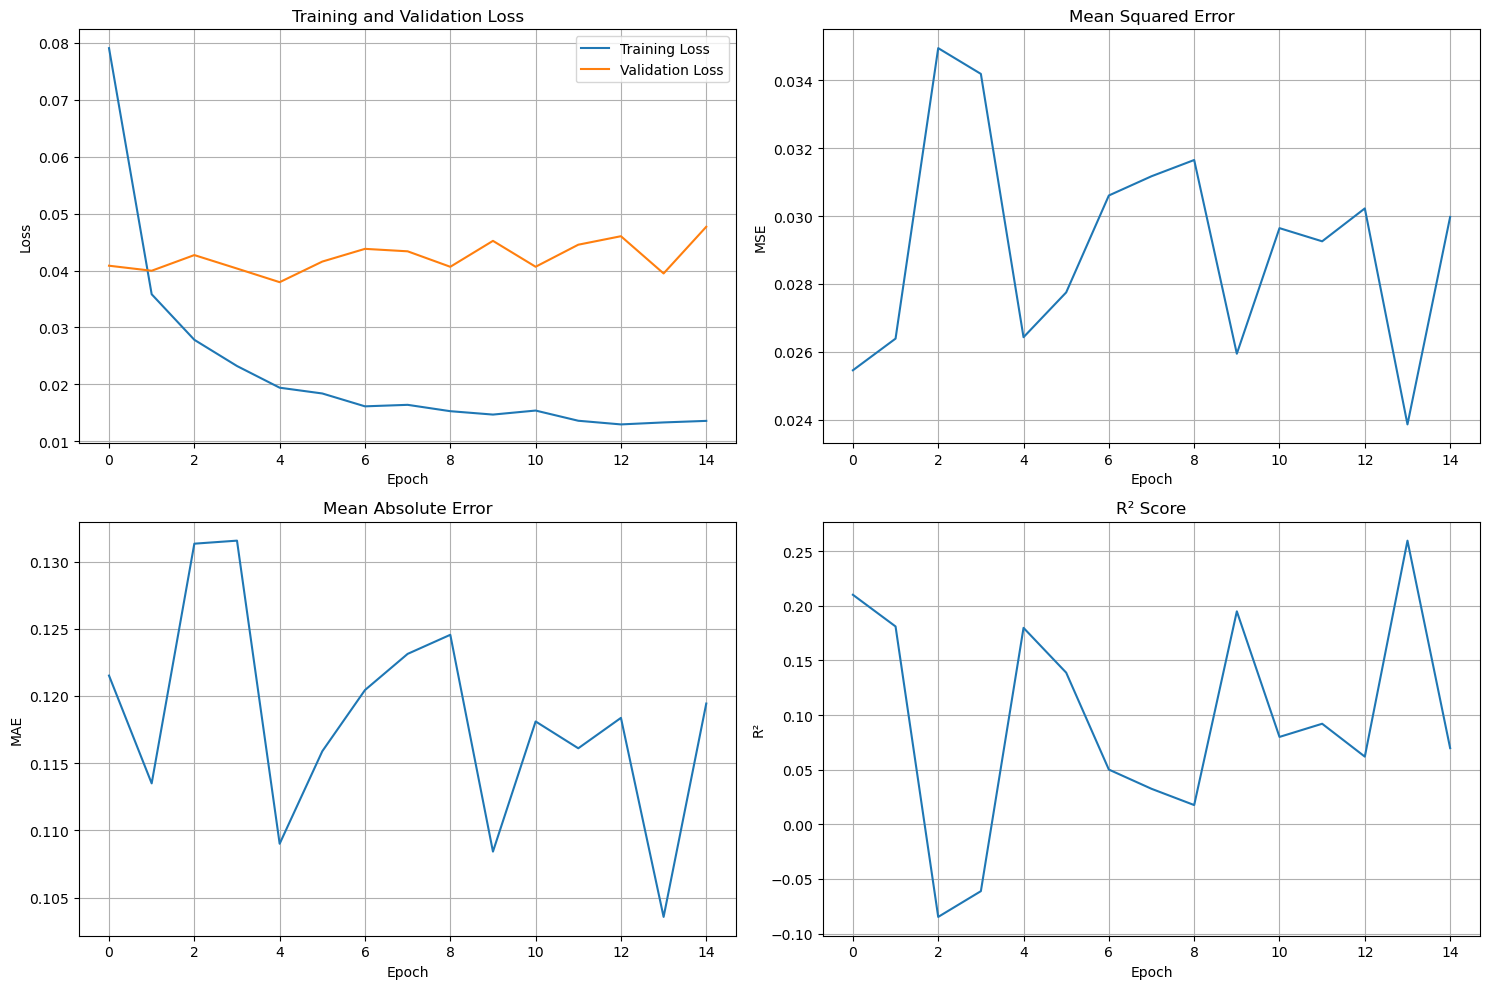

In [3]:
# ====================== 3. Define and Train the TFT Model ======================

# Model parameters
hidden_dim = 64
lstm_layers = 2
num_heads = 4
dropout = 0.1
batch_size = 64
learning_rate = 0.001
num_epochs = 50

# Define the TFT model with correct input sizes based on actual data
model = TemporalFusionTransformer(
    static_input_sizes=[],  # No static inputs
    encoder_input_sizes=[6, 18],  # Actual dimensions from your encoder inputs
    decoder_input_sizes=[6],  # Actual dimensions from your decoder inputs
    hidden_dim=hidden_dim,
    lstm_layers=lstm_layers,
    lstm_dropout=dropout,
    dropout=dropout,
    num_heads=num_heads,
    forecast_horizon=forecast_horizon,
    backcast_length=backcast_length,
    output_dim=1,  # Predicting one value (price)
    quantiles=[0.1, 0.5, 0.9]  # For uncertainty estimation
).to(device)

print(f"Model initialized successfully on {device}")

# Loss function for quantile regression
def quantile_loss(y_pred, y_true, quantiles):
    """
    Calculate quantile loss for multiple quantiles
    """
    losses = []
    for i, q in enumerate(quantiles):
        errors = y_true - y_pred[..., i]
        losses.append(torch.max((q - 1) * errors, q * errors).mean())
    return torch.mean(torch.stack(losses))

# Training function with validation metrics and attention weights
def train_tft_model(model, X_encoder_train, X_decoder_train, y_train,
                   X_encoder_val, X_decoder_val, y_val,
                   num_epochs, batch_size, learning_rate, 
                   quantiles=[0.1, 0.5, 0.9], early_stopping_patience=10):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                    factor=0.5, patience=5, verbose=True)
    
    train_losses = []
    val_losses = []
    val_metrics = {'mse': [], 'mae': [], 'r2': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_weights = None
    
    # Create DataLoader for training
    dataset_size = len(y_train)
    indices = list(range(dataset_size))

    # Create validation DataLoader with fixed batches
    val_dataset_size = len(y_val)
    val_indices = list(range(val_dataset_size))
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        np.random.shuffle(indices)
        epoch_loss = 0
        
        for i in range(0, dataset_size, batch_size):
            batch_indices = indices[i:min(i + batch_size, dataset_size)]
            
            # Prepare batch
            batch_X_encoder = [x[batch_indices].to(device) for x in X_encoder_train]
            batch_X_decoder = [x[batch_indices].to(device) for x in X_decoder_train]
            batch_y = y_train[batch_indices].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(
                static_inputs=None,  # No static inputs
                encoder_inputs=batch_X_encoder, 
                decoder_inputs=batch_X_decoder
            )
            
            # Calculate loss
            loss = quantile_loss(outputs, batch_y.unsqueeze(-1), quantiles)
            
            # Backward and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add gradient clipping
            optimizer.step()
            
            epoch_loss += loss.item() * len(batch_indices)
        
        # Average loss for the epoch
        epoch_loss /= dataset_size
        train_losses.append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for i in range(0, val_dataset_size, batch_size):
                batch_indices = val_indices[i:min(i + batch_size, val_dataset_size)]
                
                # Prepare batch
                batch_X_encoder = [x[batch_indices].to(device) for x in X_encoder_val]
                batch_X_decoder = [x[batch_indices].to(device) for x in X_decoder_val]
                batch_y = y_val[batch_indices].to(device)
                
                # Forward pass
                outputs = model(
                    static_inputs=None,  # No static inputs
                    encoder_inputs=batch_X_encoder, 
                    decoder_inputs=batch_X_decoder
                )
                
                # Store predictions and targets for metric calculation
                all_preds.append(outputs[:, :, 0, 1].cpu().numpy())  # Median prediction (0.5 quantile)
                all_targets.append(batch_y.cpu().numpy())
                
                # Calculate loss
                loss = quantile_loss(outputs, batch_y.unsqueeze(-1), quantiles)
                val_loss += loss.item() * len(batch_indices)
        
        # Combine predictions and targets
        all_preds = np.concatenate([p.reshape(-1) for p in all_preds])
        all_targets = np.concatenate([t.reshape(-1) for t in all_targets])
        
        # Calculate metrics
        mse = mean_squared_error(all_targets, all_preds)
        mae = mean_absolute_error(all_targets, all_preds)
        r2 = r2_score(all_targets, all_preds)
        
        # Store metrics
        val_metrics['mse'].append(mse)
        val_metrics['mae'].append(mae)
        val_metrics['r2'].append(r2)
        
        # Average validation loss
        val_loss /= val_dataset_size
        val_losses.append(val_loss)
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_weights = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

        # Sample attention weights every 10 epochs
        if (epoch + 1) % 10 == 0:
            print("Analyzing attention weights...")
            # Get a sample batch with attention weights
            sample_indices = val_indices[:min(5, val_dataset_size)]
            sample_X_encoder = [x[sample_indices].to(device) for x in X_encoder_val]
            sample_X_decoder = [x[sample_indices].to(device) for x in X_decoder_val]
            
            with torch.no_grad():
                _, attention_outputs = model(
                    static_inputs=None,
                    encoder_inputs=sample_X_encoder,
                    decoder_inputs=sample_X_decoder,
                    return_attention=True
                )
                
                # Print encoder-decoder attention (most important for interpretability)
                if 'decoder_encoder_attention' in attention_outputs:
                    dec_enc_attn = attention_outputs['decoder_encoder_attention']
                    print(f"Decoder-Encoder attention shape: {dec_enc_attn.shape}")
                    print(f"Attention stats - Min: {dec_enc_attn.min().item():.4f}, "
                          f"Max: {dec_enc_attn.max().item():.4f}, "
                          f"Mean: {dec_enc_attn.mean().item():.4f}")
    
    # Load best model if early stopping was triggered
    if best_model_weights is not None and patience_counter >= early_stopping_patience:
        model.load_state_dict(best_model_weights)
    
    return model, train_losses, val_losses, val_metrics

# Split validation set from training set
val_size = int(0.2 * len(X_encoder_train[0]))
X_encoder_val = [x[-val_size:] for x in X_encoder_train]
X_decoder_val = [x[-val_size:] for x in X_decoder_train]
y_val = y_train[-val_size:]

X_encoder_train = [x[:-val_size] for x in X_encoder_train]
X_decoder_train = [x[:-val_size] for x in X_decoder_train]
y_train = y_train[:-val_size]

print(f"Training set size: {len(y_train)}")
print(f"Validation set size: {len(y_val)}")

# Train the model
model, train_losses, val_losses, val_metrics = train_tft_model(
    model, X_encoder_train, X_decoder_train, y_train,
    X_encoder_val, X_decoder_val, y_val,
    num_epochs, batch_size, learning_rate, 
    early_stopping_patience=10
)

# Plot training and validation loss
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(val_metrics['mse'], label='MSE')
plt.title('Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(val_metrics['mae'], label='MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(val_metrics['r2'], label='R²')
plt.title('R² Score')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.grid(True)

plt.tight_layout()
plt.show()